In [1]:
from google.colab import files

# Upload your zip file (you already have "archive (2).zip")
uploaded = files.upload()

Saving archive (2).zip to archive (2).zip


In [2]:
import zipfile
import os

zip_path = "/content/archive (2).zip"  # name of your uploaded file
extract_path = "/content/dataset"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")


Extraction complete!


In [3]:
# Check how folders are inside
for root, dirs, files in os.walk(extract_path):
    print(root, "->", len(dirs), "folders,", len(files), "files")


/content/dataset -> 1 folders, 0 files
/content/dataset/TrashType_Image_Dataset -> 6 folders, 0 files
/content/dataset/TrashType_Image_Dataset/metal -> 0 folders, 410 files
/content/dataset/TrashType_Image_Dataset/cardboard -> 0 folders, 403 files
/content/dataset/TrashType_Image_Dataset/trash -> 0 folders, 137 files
/content/dataset/TrashType_Image_Dataset/glass -> 0 folders, 501 files
/content/dataset/TrashType_Image_Dataset/plastic -> 0 folders, 482 files
/content/dataset/TrashType_Image_Dataset/paper -> 0 folders, 594 files


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [5]:

dataset_dir = "/content/dataset/TrashType_Image_Dataset"

# Create test directory
import shutil
test_dir = "/content/dataset/test_data"
os.makedirs(test_dir, exist_ok=True)

# Move 10% of each class to test folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        files = os.listdir(class_path)
        np.random.shuffle(files)
        n_test = int(len(files) * 0.1)  # 10% for test
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(test_class_dir, exist_ok=True)
        for f in files[:n_test]:
            shutil.move(os.path.join(class_path, f), os.path.join(test_class_dir, f))

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% val from remaining
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1824 images belonging to 6 classes.
Found 452 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


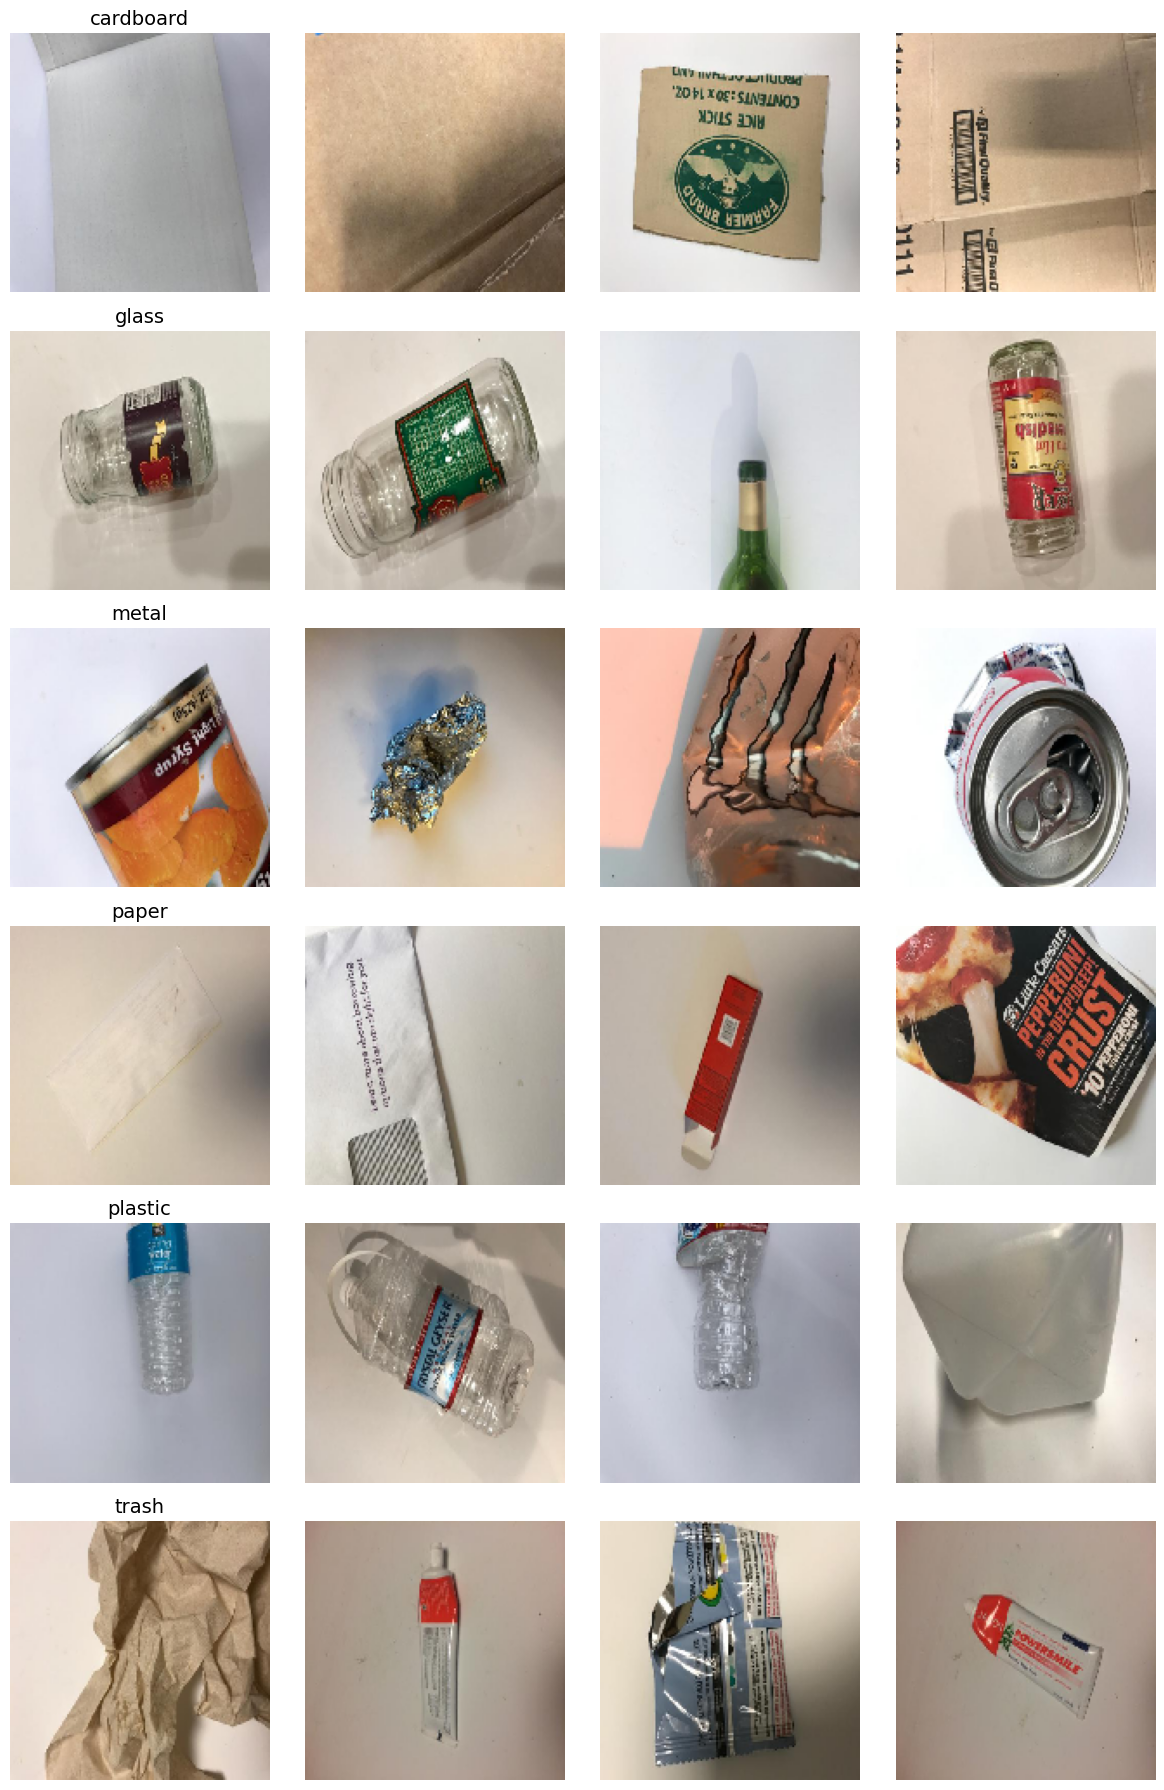

In [6]:
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)

fig, axes = plt.subplots(len(class_names), 4, figsize=(12, len(class_names) * 3))

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_dir, class_name)
    imgs = os.listdir(class_folder)[:4]
    for j, img_name in enumerate(imgs):
        img_path = os.path.join(class_folder, img_name)
        img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off')
        if j == 0:
            ax.set_title(class_name, fontsize=14)

plt.tight_layout()
plt.show()


/tmp/ipython-input-7-3601911971.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
/tmp/ipython-input-7-3601911971.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
/tmp/ipython-input-7-3601911971.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)


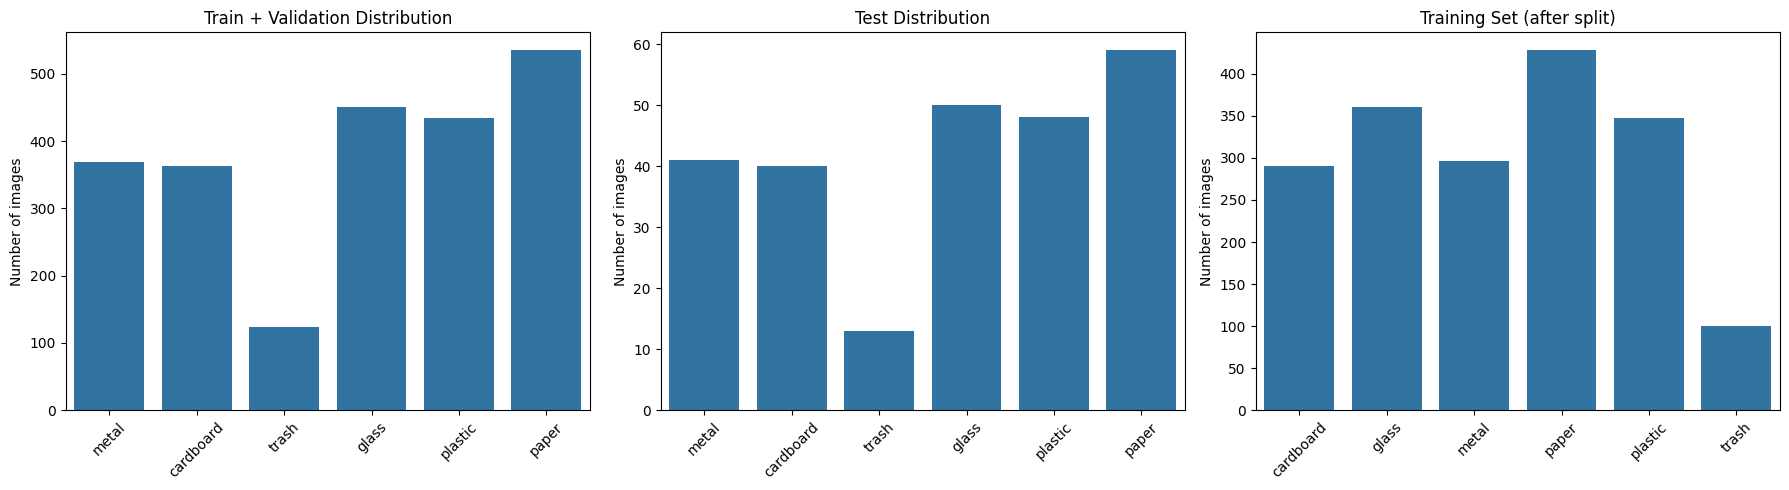

In [7]:
# Count number of images per class
def count_images(folder):
    count = {}
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            count[class_name] = len(os.listdir(class_path))
    return count

train_counts = count_images(dataset_dir)
test_counts = count_images(test_dir)

# Plot distributions
fig, ax = plt.subplots(1, 3, figsize=(18,5))

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0])
ax[0].set_title("Train + Validation Distribution")
ax[0].set_ylabel("Number of images")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[1])
ax[1].set_title("Test Distribution")
ax[1].set_ylabel("Number of images")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

sns.barplot(x=train_generator.class_indices.keys(), y=np.bincount(train_generator.classes), ax=ax[2])
ax[2].set_title("Training Set (after split)")
ax[2].set_ylabel("Number of images")
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),   # Regularization
    layers.Dense(train_generator.num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,661,606 (29.23 MB)

 Trainable params: 7,661,606 (29.23 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 317ms/step - accuracy: 0.2645 - loss: 1.7392 - val_accuracy: 0.3252 - val_loss: 1.5784
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.3600 - loss: 1.5028 - val_accuracy: 0.4358 - val_loss: 1.3912
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 310ms/step - accuracy: 0.4385 - loss: 1.4091 - val_accuracy: 0.4779 - val_loss: 1.3635
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - accuracy: 0.4633 - loss: 1.3128 - val_accuracy: 0.4823 - val_loss: 1.3386
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.4494 - loss: 1.3343 - val_accuracy: 0.4823 - val_loss: 1.2977
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - accuracy: 0.4788 - loss: 1.3035 - val_accuracy: 0.4779 - val_loss: 1.3255
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 308ms/step - accuracy: 0.4795 - loss: 1.2568 - val_accuracy: 0.5155 - val_loss: 1.2391
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - accuracy: 0.4975 - loss: 1.2807 - val_accu

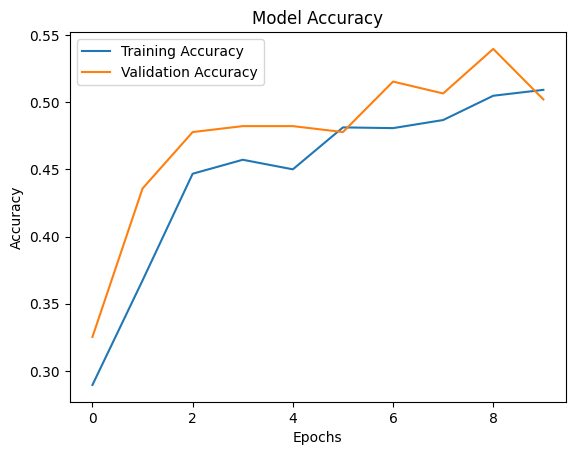

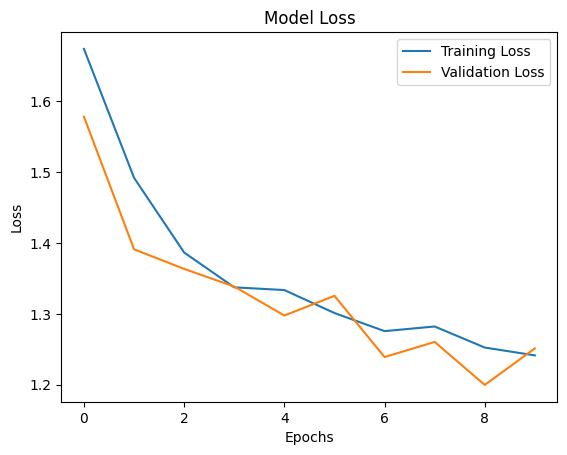

In [12]:
# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [13]:
# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.5161 - loss: 1.1778
Test Accuracy: 50.20%
Test Loss: 1.2127


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step


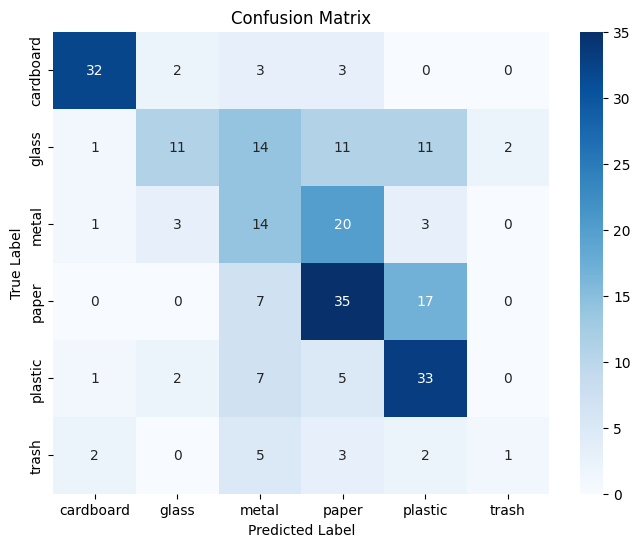

              precision    recall  f1-score   support

   cardboard       0.86      0.80      0.83        40
       glass       0.61      0.22      0.32        50
       metal       0.28      0.34      0.31        41
       paper       0.45      0.59      0.51        59
     plastic       0.50      0.69      0.58        48
       trash       0.33      0.08      0.12        13

    accuracy                           0.50       251
   macro avg       0.51      0.45      0.45       251
weighted avg       0.53      0.50      0.49       251



In [14]:
# Predict on test set
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


In [15]:
model.save('/content/cnn_trash_model_v2.h5')
print("Model saved as cnn_trash_model_v2.h5")


Model saved as cnn_trash_model_v2.h5
